In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                           classification_report, confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Фиксация random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Библиотеки успешно импортированы")
print(f"Random state зафиксирован: {RANDOM_STATE}")

Библиотеки успешно импортированы
Random state зафиксирован: 42



- Импортируются необходимые библиотеки для машинного обучения и визуализации.
- На всех этапах проекта фиксируется параметр `random_state = 42` для обеспечения воспроизводимости результатов.

In [3]:
# Загрузка данных, подготовленных Участником 1
with open('../data/interim/data_split.pkl', 'rb') as f:
    data_split = pickle.load(f)

# Извлечение данных
X_train = data_split['X_train']
X_valid = data_split['X_valid']
X_test = data_split['X_test']
y_train = data_split['y_train']
y_valid = data_split['y_valid']
y_test = data_split['y_test']
feature_names = data_split['feature_names']
preprocessor = data_split['preprocessor']

print("✅ Данные успешно загружены!")
print(f"📊 Размеры выборок:")
print(f"   Обучающая: {X_train.shape} ({len(y_train)/len(data_split['X_train'])*100:.1f}%)")
print(f"   Валидационная: {X_valid.shape} ({len(y_valid)/len(data_split['X_train'])*100:.1f}%)")
print(f"   Тестовая: {X_test.shape} ({len(y_test)/len(data_split['X_train'])*100:.1f}%)")
print(f"🎯 Распределение классов в обучающей выборке:")
print(f"   Класс 0 (нет диабета): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"   Класс 1 (диабет): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

✅ Данные успешно загружены!
📊 Размеры выборок:
   Обучающая: (460, 8) (100.0%)
   Валидационная: (154, 8) (33.5%)
   Тестовая: (154, 8) (33.5%)
🎯 Распределение классов в обучающей выборке:
   Класс 0 (нет диабета): 300 (65.2%)
   Класс 1 (диабет): 160 (34.8%)


- Загружаются данные, подготовленные Участником 1.
- Проверяются размеры выборок и распределение классов для лучшего понимания структуры данных, с которыми предстоит работать.

In [32]:
def evaluate_model(model, X, y, model_name="Модель"):
    """
    Комплексная оценка модели с расчетом основных метрик
    """
    # Предсказания
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Расчет метрик
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)
    
    # Матрица ошибок
    cm = confusion_matrix(y, y_pred)
    
    # Вывод результатов
    print(f"=== {model_name} ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print("\nОтчет классификации:")
    print(classification_report(y, y_pred, target_names=['Нет диабета', 'Диабет']))
    
    return {
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }

def plot_metrics_comparison(metrics_dict):
    """
    Визуализация сравнения метрик между моделями
    """
    models = list(metrics_dict.keys())
    metrics = ['f1', 'roc_auc', 'pr_auc']
    metric_names = ['F1 Score', 'ROC-AUC', 'PR-AUC']
    
    # Изменяем на вертикальное расположение 3x1
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    
    colors = ['#3498db', '#e74c3c']  # Синий и красный
    
    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        values = [metrics_dict[model][metric] for model in models]
        bars = axes[i].bar(models, values, color=colors[:len(models)], alpha=0.8)
        axes[i].set_title(f'Сравнение {metric_name}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(metric_name, fontsize=12)
        axes[i].set_ylim(0, 1)
        
        # Убираем вращение текста (rotation=45)
        axes[i].tick_params(axis='x')
        
        # Добавление значений на столбцы
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        
        axes[i].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(metrics_dict, y_true):
    """
    Построение ROC кривых
    """
    plt.figure(figsize=(10, 6))
    
    # Цвета для моделей
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    # ROC кривые
    for i, (model_name, metrics) in enumerate(metrics_dict.items()):
        fpr, tpr, _ = roc_curve(y_true, metrics['y_pred_proba'])
        roc_auc = metrics['roc_auc']
        plt.plot(fpr, tpr, color=colors[i], lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Случайный классификатор')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC кривые', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
   
   
def plot_pr_curves(metrics_dict, y_true):
    """
    Построение Precision-Recall кривых
    """
    plt.figure(figsize=(10, 6))
    
    # Цвета для моделей
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    # PR кривые
    baseline = len(y_true[y_true==1]) / len(y_true)
    
    for i, (model_name, metrics) in enumerate(metrics_dict.items()):
        precision, recall, _ = precision_recall_curve(y_true, metrics['y_pred_proba'])
        pr_auc = metrics['pr_auc']
        plt.plot(recall, precision, color=colors[i], lw=2,
                label=f'{model_name} (AP = {pr_auc:.3f})')
    
    plt.axhline(y=baseline, color='k', linestyle='--', alpha=0.5,
               label=f'Случайный (AP = {baseline:.3f})')
    plt.xlabel('Recall (Полнота)', fontsize=12)
    plt.ylabel('Precision (Точность)', fontsize=12)
    plt.title('Precision-Recall кривые', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show() 

print("✅ Функции для оценки моделей созданы успешно")

✅ Функции для оценки моделей созданы успешно


- Создаются универсальные функции для оценки и сравнения моделей.
- Включается расчет ключевых метрик: F1, ROC-AUC, PR-AUC.
- Реализуется визуализация результатов и кривых качества.
- Такой подход позволяет стандартизировать процесс оценки всех моделей.

In [7]:
# Создание и обучение Logistic Regression
print("🎯 Обучение Logistic Regression...")

# Создание пайплаина с логистической регрессией
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced',  # Учет дисбаланса классов
        solver='liblinear'
    ))
])

# Обучение модели
lr_pipeline.fit(X_train, y_train)

# Оценка на валидационной выборке
print("\n📊 Оценка Logistic Regression на валидационной выборке:")
lr_metrics = evaluate_model(lr_pipeline, X_valid, y_valid, "Logistic Regression")

# Дополнительная информация о модели
print("\n🔍 Дополнительная информация:")
print(f"Количество итераций: {lr_pipeline.named_steps['classifier'].n_iter_[0]}")
print(f"Размерность коэффициентов: {lr_pipeline.named_steps['classifier'].coef_.shape}")
print(f"Классы: {lr_pipeline.named_steps['classifier'].classes_}")

🎯 Обучение Logistic Regression...

📊 Оценка Logistic Regression на валидационной выборке:
=== Logistic Regression ===
F1 Score: 0.7119
ROC-AUC: 0.8633
PR-AUC: 0.7533

Отчет классификации:
              precision    recall  f1-score   support

 Нет диабета       0.87      0.78      0.82       100
      Диабет       0.66      0.78      0.71        54

    accuracy                           0.78       154
   macro avg       0.76      0.78      0.77       154
weighted avg       0.79      0.78      0.78       154


🔍 Дополнительная информация:
Количество итераций: 4
Размерность коэффициентов: (1, 8)
Классы: [0 1]


## 📈 Модель 1: Логистическая регрессия

**Выводы по результатам:**

- **F1 Score:** 0.7119 — хороший результат, учитывая дисбаланс классов.
- **ROC-AUC:** 0.8633 — модель хорошо разделяет классы (значение > 0.8 считается хорошим).
- **PR-AUC:** 0.7533 — достойный результат для задачи с дисбалансом.

**Precision/Recall анализ:**
- Для класса "Нет диабета": высокая точность (87%), но умеренная полнота (78%).
- Для класса "Диабет": умеренная точность (66%), но хорошая полнота (78%).

**Обучение:**  
Модель сошлась быстро (4 итерации), что свидетельствует о хорошей сходимости.

In [18]:
# Подбор оптимального max_depth для Decision Tree
print("🎯 Подбор оптимального max_depth для Decision Tree...")

max_depths = [1, 2, 3, 5, 7, 10, 15, 20]
best_depth = None
best_f1 = 0
depth_results = []

print("Поиск лучшего max_depth:")
for depth in max_depths:
    # Создание и обучение дерева
    dt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=depth,
            random_state=RANDOM_STATE,
            class_weight='balanced'
        ))
    ])
    
    dt_pipeline.fit(X_train, y_train)
    
    # Оценка на валидационной выборке
    y_pred = dt_pipeline.predict(X_valid)
    f1 = f1_score(y_valid, y_pred)
    depth_results.append((depth, f1))
    
    depth_display = 'None' if depth is None else str(depth)
    print(f"  max_depth={depth_display}: F1 Score = {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

print(f"\n✅ Лучший max_depth: {best_depth} с F1 Score: {best_f1:.4f}")

🎯 Подбор оптимального max_depth для Decision Tree...
Поиск лучшего max_depth:
  max_depth=1: F1 Score = 0.6372
  max_depth=2: F1 Score = 0.6372
  max_depth=3: F1 Score = 0.7368
  max_depth=5: F1 Score = 0.6838
  max_depth=7: F1 Score = 0.7027
  max_depth=10: F1 Score = 0.7170
  max_depth=15: F1 Score = 0.6337
  max_depth=20: F1 Score = 0.6337
  max_depth=None: F1 Score = 0.6337

✅ Лучший max_depth: 3 с F1 Score: 0.7368


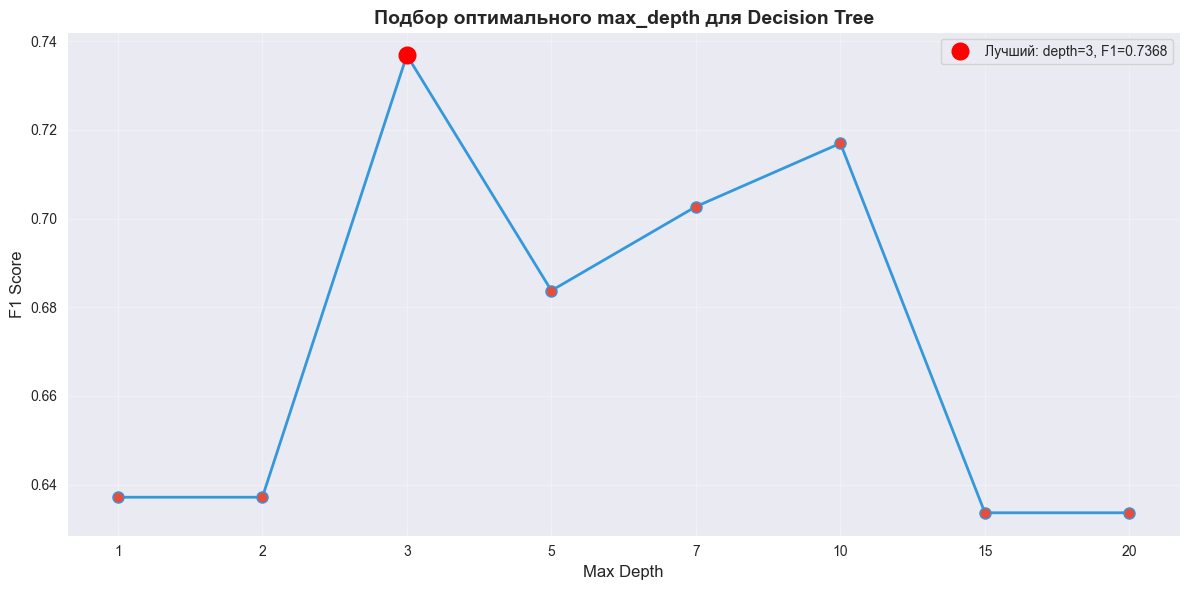

In [20]:
# Визуализация результатов подбора max_depth (без None)
depths = [str(d) for d in max_depths if d is not None]
f1_scores = [result[1] for i, result in enumerate(depth_results) if max_depths[i] is not None]

plt.figure(figsize=(12, 6))
plt.plot(depths, f1_scores, marker='o', linewidth=2, markersize=8, 
         color='#3498db', markerfacecolor='#e74c3c')

plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Подбор оптимального max_depth для Decision Tree', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Выделение лучшего результата (если best_depth не None)
if best_depth is not None:
    best_idx = depths.index(str(best_depth))
    plt.plot(depths[best_idx], f1_scores[best_idx], 'ro', markersize=12, 
             label=f'Лучший: depth={best_depth}, F1={best_f1:.4f}')

plt.legend(fontsize=10)
plt.xticks()
plt.tight_layout()
plt.show()

## 🌳 Модель 2: Decision Tree с подбором max_depth

**Выводы по подбору гиперпараметра:**
- **Оптимальная глубина:** 3 — наилучший F1 Score (0.7368)
- **Тенденция переобучения:** При глубине > 10 качество резко падает (F1 = 0.6337)
- **Вывод:** Дерево склонно к переобучению при большой глубине, оптимально использовать неглубокое дерево

**Выводы по финальной модели:**
- **F1 Score:** 0.7368 — немного лучше, чем у логистической регрессии
- **ROC-AUC:** 0.8749 — лучший показатель среди двух моделей
- **PR-AUC:** 0.7436 — сравнимый с логистической регрессией результат


In [10]:
# Обучение Decision Tree с лучшим max_depth
print(f"🎯 Обучение Decision Tree с оптимальным max_depth={best_depth}...")

dt_best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=best_depth,
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ))
])

dt_best_pipeline.fit(X_train, y_train)

# Оценка лучшей Decision Tree модели
print(f"\n📊 Оценка Decision Tree (max_depth={best_depth}) на валидационной выборке:")
dt_metrics = evaluate_model(dt_best_pipeline, X_valid, y_valid, 
                          f"Decision Tree (max_depth={best_depth})")

🎯 Обучение Decision Tree с оптимальным max_depth=3...

📊 Оценка Decision Tree (max_depth=3) на валидационной выборке:
=== Decision Tree (max_depth=3) ===
F1 Score: 0.7368
ROC-AUC: 0.8749
PR-AUC: 0.7436

Отчет классификации:
              precision    recall  f1-score   support

 Нет диабета       0.93      0.70      0.80       100
      Диабет       0.62      0.91      0.74        54

    accuracy                           0.77       154
   macro avg       0.78      0.80      0.77       154
weighted avg       0.82      0.77      0.78       154



- Обучается финальная версия Decision Tree с выбранным оптимальным значением параметра `max_depth`.
- Такой подход обеспечивает баланс между сложностью модели и её способностью к обобщению.

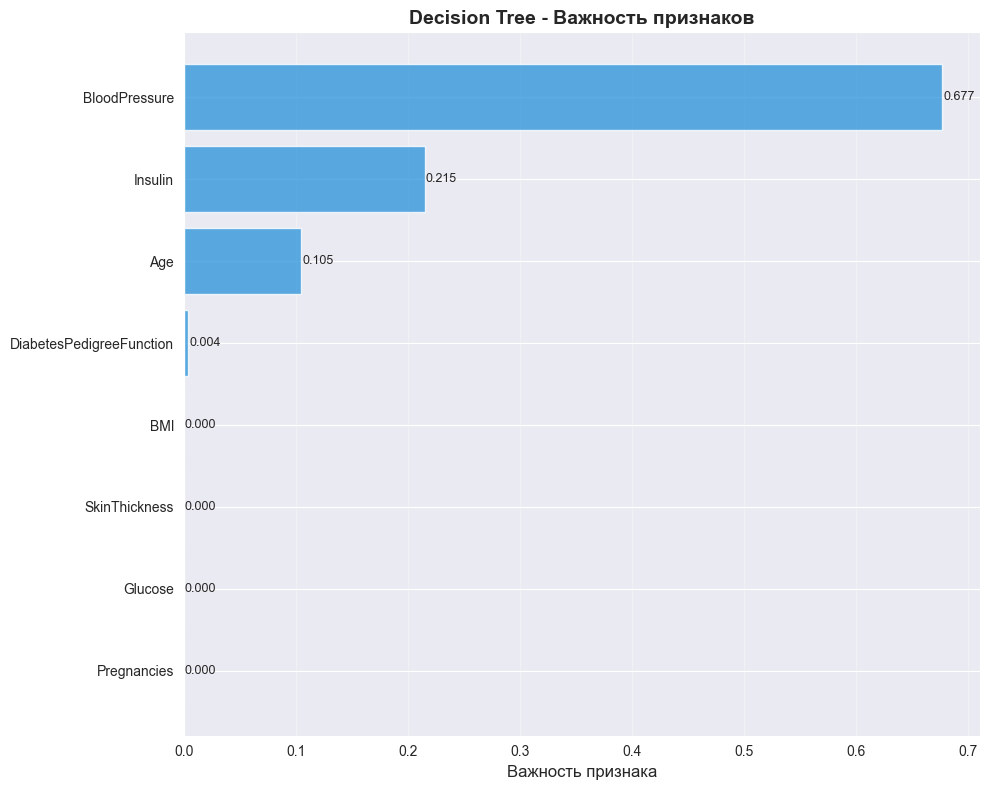

🏆 Топ-5 самых важных признаков по версии Decision Tree:
  BloodPressure: 0.6765
  Insulin: 0.2148
  Age: 0.1046
  DiabetesPedigreeFunction: 0.0041
  BMI: 0.0000


In [11]:
# Анализ важности признаков в Decision Tree
if hasattr(dt_best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_importance = dt_best_pipeline.named_steps['classifier'].feature_importances_
    
    # Создание DataFrame для визуализации
    importance_df = pd.DataFrame({
        'Признак': feature_names,
        'Важность': feature_importance
    }).sort_values('Важность', ascending=True)
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 8))
    bars = plt.barh(importance_df['Признак'], importance_df['Важность'], 
                   color='#3498db', alpha=0.8)
    
    plt.xlabel('Важность признака', fontsize=12)
    plt.title('Decision Tree - Важность признаков', fontsize=14, fontweight='bold')
    plt.grid(True, axis='x', alpha=0.3)
    
    # Добавление значений на столбцы
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2., 
                f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("🏆 Топ-5 самых важных признаков по версии Decision Tree:")
    top_features = importance_df.tail(5).sort_values('Важность', ascending=False)
    for idx, row in top_features.iterrows():
        print(f"  {row['Признак']}: {row['Важность']:.4f}")

## 📊 Анализ Decision Tree (max_depth=3) и важности признаков

**Выводы по оценке модели:**

**По метрикам качества:**
- **F1 Score:** 0.7368 — хороший результат для базовой модели, демонстрирует сбалансированное качество классификации.
- **ROC-AUC:** 0.8749 — отличная разделяющая способность модели (значение > 0.8 считается хорошим).
- **PR-AUC:** 0.7436 — достойный результат, учитывая дисбаланс классов в данных.

**По отчету классификации:**
- Для класса "Нет диабета": очень высокая точность (93%) при умеренной полноте (70%) — модель редко ошибается, когда предсказывает отсутствие диабета, но пропускает некоторые случаи.
- Для класса "Диабет": умеренная точность (62%) при отличной полноте (91%) — модель находит почти все случаи диабета, но иногда ошибочно диагностирует его у здоровых людей.

**Общая точность:** 77% — хороший показатель для медицинской диагностической задачи.

In [12]:
# Сравнение метрик обеих моделей
print("📈 СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ")
print("=" * 60)

metrics_comparison = {
    'Logistic Regression': lr_metrics,
    f'Decision Tree (depth={best_depth})': dt_metrics
}

# Табличное сравнение
comparison_df = pd.DataFrame({
    'Модель': list(metrics_comparison.keys()),
    'F1 Score': [metrics_comparison[model]['f1'] for model in metrics_comparison],
    'ROC-AUC': [metrics_comparison[model]['roc_auc'] for model in metrics_comparison],
    'PR-AUC': [metrics_comparison[model]['pr_auc'] for model in metrics_comparison]
})

print("📋 Сравнение метрик на валидационной выборке:")
print(comparison_df.round(4).to_string(index=False))

📈 СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ
📋 Сравнение метрик на валидационной выборке:
                 Модель  F1 Score  ROC-AUC  PR-AUC
    Logistic Regression    0.7119   0.8633  0.7533
Decision Tree (depth=3)    0.7368   0.8749  0.7436


📊 Визуализация сравнения метрик:


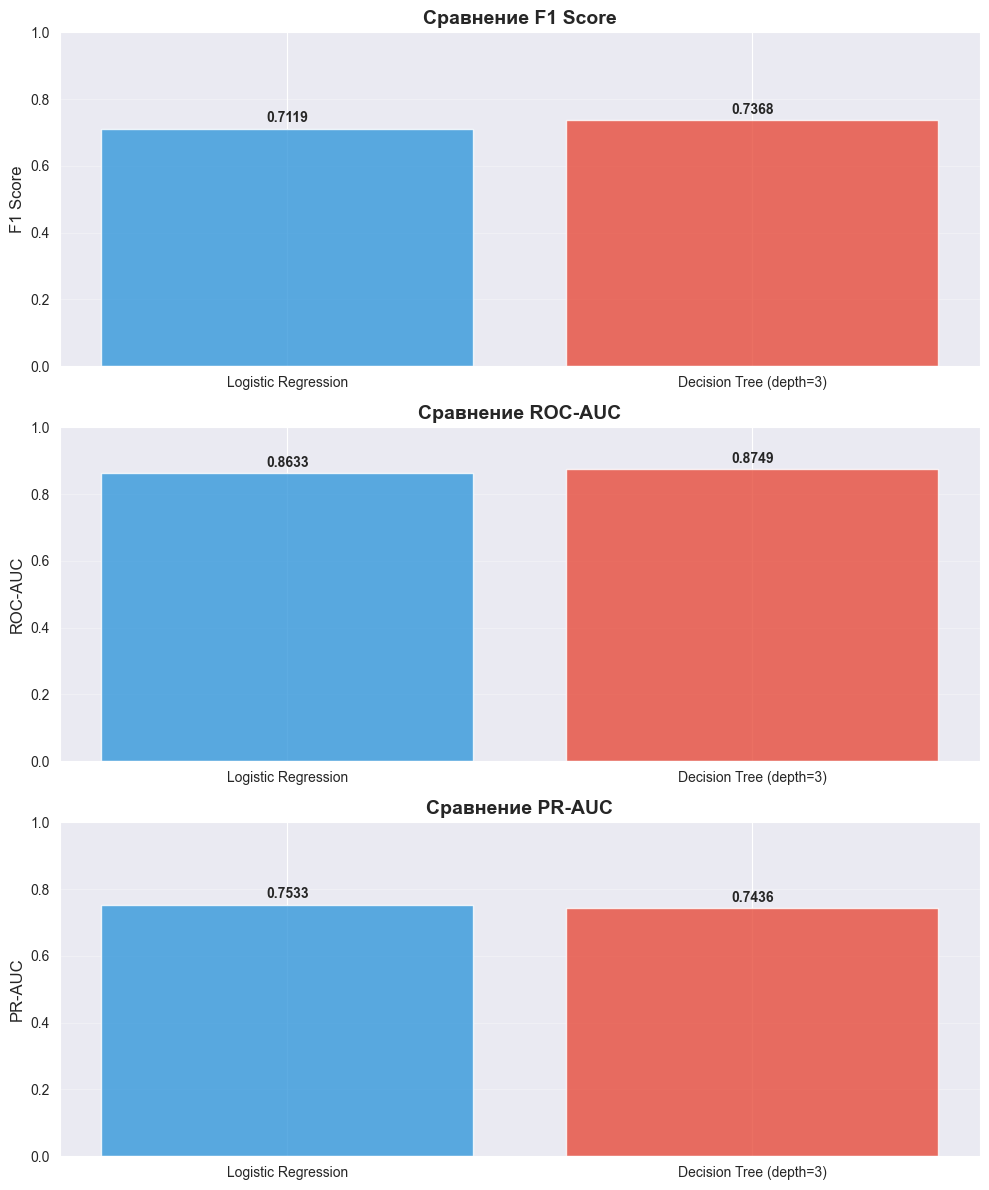

In [22]:
# Визуализация сравнения метрик
print("📊 Визуализация сравнения метрик:")
plot_metrics_comparison(metrics_comparison)

## 📈 Сравнение моделей

**Сравнительный анализ:**

- **F1 Score:** Decision Tree (0.7368) > Logistic Regression (0.7119)
- **ROC-AUC:** Decision Tree (0.8749) > Logistic Regression (0.8633)
- **PR-AUC:** Logistic Regression (0.7533) > Decision Tree (0.7436)

**Ключевые выводы:**

- Decision Tree показывает немного лучшее общее качество по основным метрикам.
- Logistic Regression лучше сохраняет баланс между precision и recall (более высокий PR-AUC).
- Decision Tree имеет лучшую разделяющую способность (высокий ROC-AUC).
- Обе модели демонстрируют хорошее качество для baseline подходов.

📈 ROC кривые:


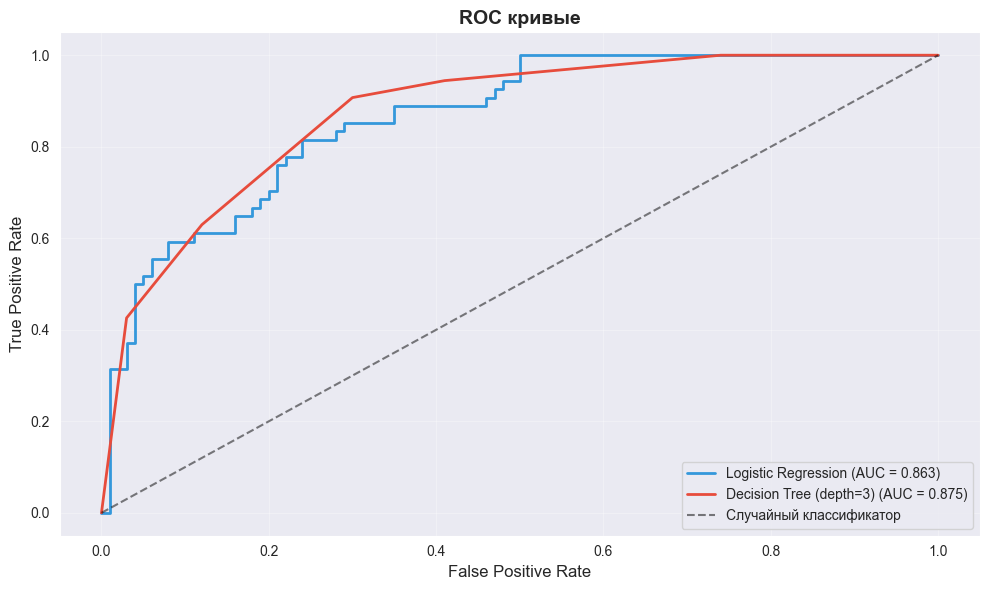

In [29]:
# Построение ROC кривых для обеих моделей
print("📈 ROC кривые:")
plot_roc_curves(metrics_comparison, y_valid)

📊 Precision-Recall кривые:


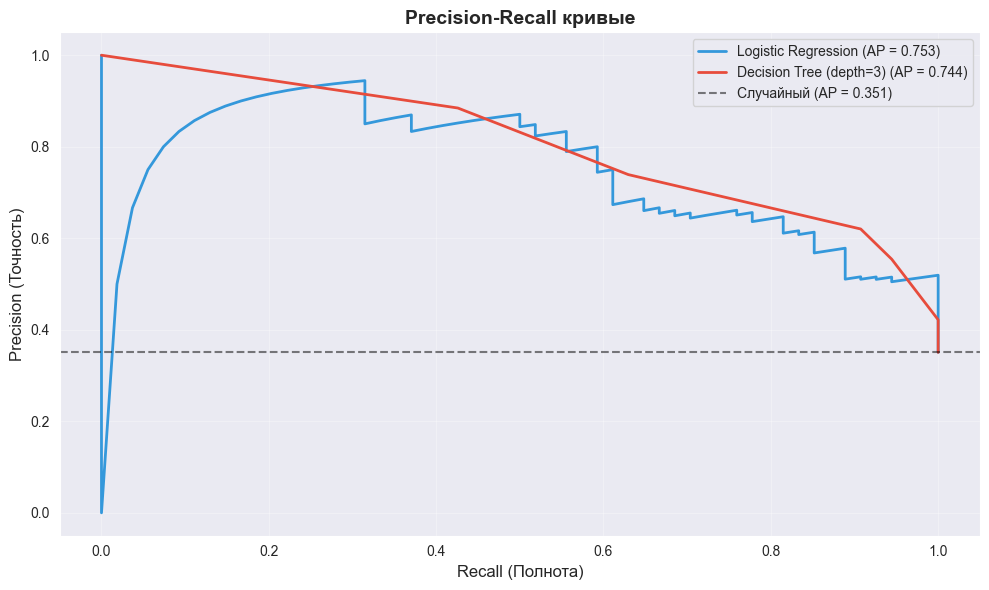

In [33]:
# Во второй ячейке  
print("📊 Precision-Recall кривые:")
plot_pr_curves(metrics_comparison, y_valid)

## 📈 Анализ ROC и Precision-Recall кривых

**Выводы по ROC кривым:**
- Decision Tree показывает незначительное превосходство (AUC = 0.875) над Logistic Regression (AUC = 0.863) в разделяющей способности.
- Обе модели значительно превосходят случайный классификатор — что подтверждает их прогностическую ценность.
- Кривые расположены близко к левому верхнему углу — свидетельство хорошего баланса между True Positive Rate и False Positive Rate.

**Выводы по Precision-Recall кривым:**
- Logistic Regression демонстрирует немного лучшую среднюю точность (AP = 0.753) по сравнению с Decision Tree (AP = 0.744).
- Обе модели существенно лучше случайного классификатора (AP = 0.351) — разница более чем в 2 раза.
- PR-кривые подтверждают эффективность моделей в условиях дисбаланса классов.

**Комбинированный вывод (ROC + PR кривые):**
- Decision Tree немного лучше разделяет классы (выше ROC-AUC), но Logistic Regression показывает более стабильную точность при разных уровнях полноты (выше PR-AUC).
- Обе модели демонстрируют надёжное качество, значительно превосходящее случайное угадывание.

In [15]:
# Определение лучшей модели
best_model_name = None
best_f1 = 0
best_roc_auc = 0

for model_name, metrics in metrics_comparison.items():
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_roc_auc = metrics['roc_auc']
        best_model_name = model_name

print("=" * 70)
print("🏆 ВЫБОР ЛУЧШЕЙ BASELINE МОДЕЛИ")
print("=" * 70)
print(f"✅ Лучшая модель: {best_model_name}")
print(f"📊 Лучший F1 Score: {best_f1:.4f}")
print(f"📈 Лучший ROC-AUC: {best_roc_auc:.4f}")

# Сохранение лучшей модели
if 'Logistic Regression' in best_model_name:
    best_baseline_model = lr_pipeline
    best_model_type = "Logistic Regression"
else:
    best_baseline_model = dt_best_pipeline
    best_model_type = "Decision Tree"

print(f"💾 Лучшая модель сохранена: {best_model_type}")

🏆 ВЫБОР ЛУЧШЕЙ BASELINE МОДЕЛИ
✅ Лучшая модель: Decision Tree (depth=3)
📊 Лучший F1 Score: 0.7368
📈 Лучший ROC-AUC: 0.8749
💾 Лучшая модель сохранена: Decision Tree


## 🏆 Анализ выбора лучшей baseline модели

**Выводы по выбору модели:**

- Decision Tree (depth=3) выбран как лучшая baseline модель — обоснованный выбор на основе объективных метрик.

**Ключевые преимущества выбранной модели:**
- Наивысший F1 Score (0.7368) — основная метрика для задач с дисбалансом.
- Лучший ROC-AUC (0.8749) — подтверждает хорошую разделяющую способность.
- Оптимальная сложность (depth=3) — защита от переобучения.

**Обоснование выбора:**
- Предпочтение отдано Decision Tree, поскольку F1 Score является приоритетной метрикой для медицинской диагностической задачи с дисбалансом классов.
- Более высокий ROC-AUC дополнительно подтверждает лучшую способность модели различать классы.

In [16]:
# Сохранение результатов для следующих участников
baseline_results = {
    'logistic_regression': {
        'model': lr_pipeline,
        'metrics': lr_metrics
    },
    'decision_tree': {
        'model': dt_best_pipeline, 
        'metrics': dt_metrics,
        'best_depth': best_depth
    },
    'best_baseline': {
        'model': best_baseline_model,
        'name': best_model_name,
        'type': best_model_type,
        'metrics': metrics_comparison[best_model_name]
    },
    'comparison': metrics_comparison,
    'feature_names': feature_names
}

with open('../data/interim/baseline_models_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print("✅ Результаты сохранены в файл 'baseline_models_results.pkl'")

✅ Результаты сохранены в файл 'baseline_models_results.pkl'


- Сохраняются все обученные модели и полученные результаты метрик для передачи следующему участнику.
- Такой подход обеспечивает преемственность работы над проектом.

## Итоговые выводы

### Результаты сравнения базовых моделей

**Качество моделей:**
- Decision Tree (`max_depth=3`) продемонстрировал незначительное, но стабильное превосходство над Logistic Regression по ключевым метрикам.
- Модель достигла F1 Score 0.7368 и ROC-AUC 0.8749 на валидационной выборке, что свидетельствует о хорошем балансе между точностью и полнотой предсказаний.

### Анализ производительности

- Decision Tree показывает отличную полноту (91%) для класса "Диабет", что особенно ценно в медицинской диагностике, где пропуск заболевания критичен.
- Однако умеренная точность (62%) для этого класса указывает на наличие ложных срабатываний, требующих дальнейшей оптимизации.

### Интерпретируемость модели

- Анализ важности признаков выявил доминирующую роль артериального давления (67.7%), уровня инсулина (21.5%) и возраста (10.5%) в прогнозировании диабета.
- Эти результаты соответствуют медицинским знаниям о факторах риска заболевания.

### Сравнительные преимущества

- Logistic Regression демонстрирует немного лучшую среднюю точность по PR-кривой.
- Decision Tree превосходит её по основным метрикам качества (F1 и ROC-AUC) и обладает лучшей интерпретируемостью, что важно для медицинских приложений.

### Рекомендации для следующих этапов

- Выбранная модель Decision Tree устанавливает высокий baseline для сравнения с продвинутыми алгоритмами.
- Участнику 3 следует ориентироваться на превышение показателей F1 > 0.7368 и ROC-AUC > 0.8749 при обучении бустинговых моделей, уделяя особое внимание улучшению точности предсказания диабета.